Import and Configure GPU Memory Growth

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Set this before importing libraries

import torch
print(torch.cuda.is_available())
print(torch.cuda.current_device())


True
0


Load DataFrames and PreProcess

In [2]:
import os
import pandas as pd

# Load all CSV files from "etfs" and "stocks" directories
data_dir_etfs = './data/etfs'
data_dir_stocks = './data/stocks'

all_files = []
for directory in [data_dir_stocks, data_dir_etfs]:
    for file in os.listdir(directory):
        if file.endswith('.csv'):
            all_files.append(os.path.join(directory, file))

# Concatenate all data into a single DataFrame
data_list = []
for file in all_files:
    df = pd.read_csv(file)
    data_list.append(df)

data = pd.concat(data_list)

# Display the first few rows of the concatenated DataFrame
print("First few rows of the combined data:")
print(data.head())

# Check for missing values
print("Checking for missing values in each column:")
print(data.isnull().sum())

# Drop rows with missing values
data = data.dropna()

# Display the shape of the cleaned data
print("Shape of the cleaned data:", data.shape)

# Display the first few rows of the cleaned data
print("First few rows of the cleaned data:")
print(data.head())


First few rows of the combined data:
         Date       Open       High        Low      Close  Adj Close  \
0  1999-11-18  32.546494  35.765381  28.612303  31.473534  27.068665   
1  1999-11-19  30.713520  30.758226  28.478184  28.880543  24.838577   
2  1999-11-22  29.551144  31.473534  28.657009  31.473534  27.068665   
3  1999-11-23  30.400572  31.205294  28.612303  28.612303  24.607880   
4  1999-11-24  28.701717  29.998211  28.612303  29.372318  25.261524   

       Volume  
0  62546300.0  
1  15234100.0  
2   6577800.0  
3   5975600.0  
4   4843200.0  
Checking for missing values in each column:
Date           0
Open         683
High         683
Low          683
Close        683
Adj Close    683
Volume       683
dtype: int64
Shape of the cleaned data: (28147685, 7)
First few rows of the cleaned data:
         Date       Open       High        Low      Close  Adj Close  \
0  1999-11-18  32.546494  35.765381  28.612303  31.473534  27.068665   
1  1999-11-19  30.713520  30.758226  

PreProcessing

In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Convert 'Date' column to datetime and set as index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Check for NaN and infinity values
print("Checking for NaN values in data:", np.isnan(scaled_data).any())
print("Checking for infinity values in data:", np.isinf(scaled_data).any())

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Prepare the input and output for the model
def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), :])
        y.append(dataset[i + look_back, :])
    return np.array(X), np.array(y)

look_back = 20
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

# Display shapes of the datasets
print("Shapes of datasets:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)


Checking for NaN values in data: False
Checking for infinity values in data: False


KeyboardInterrupt: 

Build and Train

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from tqdm import tqdm  # Import tqdm for progress bars

# Set device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- Prepare the Data ---
# Assuming X_train, y_train, X_test, y_test are already defined as NumPy arrays.
# X_train shape: (num_samples, look_back, num_features)
# y_train shape: (num_samples, num_features) -- matching the Keras output layer

# Convert numpy arrays to torch tensors (float type)
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

# Create DataLoaders for training and validation/test sets
batch_size = 256
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# --- Define the Model ---
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        # First LSTM layer: return sequences
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=256, num_layers=1, batch_first=True)
        self.dropout1 = nn.Dropout(0.3)
        # Second LSTM layer: return only final output (return_sequences=False equivalent)
        self.lstm2 = nn.LSTM(input_size=256, hidden_size=256, num_layers=1, batch_first=True)
        self.dropout2 = nn.Dropout(0.3)
        # Dense output layer: same number of units as the number of features
        self.fc = nn.Linear(256, output_size)
        
    def forward(self, x):
        # x shape: (batch_size, look_back, input_size)
        out, _ = self.lstm1(x)           # out shape: (batch_size, look_back, 150)
        out = self.dropout1(out)
        out, _ = self.lstm2(out)         # out shape: (batch_size, look_back, 150)
        # Take the output at the final timestep
        out = out[:, -1, :]              # shape: (batch_size, 150)
        out = self.dropout2(out)
        out = self.fc(out)               # shape: (batch_size, output_size)
        return out

# Set parameters based on your data
look_back = X_train.shape[1]          # number of timesteps
input_size = X_train.shape[2]         # number of features
output_size = X_train.shape[2]        # same as number of features

# Instantiate the model, define the loss and optimizer
model = LSTMModel(input_size=input_size, hidden_size=128, output_size=output_size)
model = model.to(device)  # move model to GPU if available

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Regularization hyperparameters
l1_lambda = 1e-10  # adjust as needed
l2_lambda = 7e-10  # adjust as needed

# Global variables for tracking best epoch (best validation loss)
best_val_loss = float('inf')
best_epoch = -1

# --- Training Loop ---
num_epochs = 15  # (Update as needed)
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    # Training progress bar for the current epoch with white color
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False, colour='white')
    for batch_x, batch_y in train_bar:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)  # move batch data to device
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        # Compute L1 norm over all model parameters (L2 omitted here for brevity, but can be added similarly)
        l1_norm = sum(param.abs().sum() for param in model.parameters())
        l2_norm = sum(param.pow(2).sum() for param in model.parameters())
        loss = loss + l2_lambda * l2_norm
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_x.size(0)
        train_bar.set_postfix(loss=loss.item())
    epoch_loss = running_loss / len(train_loader.dataset)
    
    # Validation on test data with progress bar and white color
    model.eval()
    val_loss = 0.0
    val_bar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False, colour='white')
    with torch.no_grad():
        for batch_x, batch_y in val_bar:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item() * batch_x.size(0)
            val_bar.set_postfix(loss=loss.item())
    val_loss = val_loss / len(test_loader.dataset)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.9e}, Val Loss: {val_loss:.9e}")
    
    # Save best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch + 1  # epoch counting starts at 1
        torch.save(model.state_dict(), 'mv3_best.pth')

# Expose the best epoch and loss as global variables
print(f"Best Epoch: {best_epoch} with Val Loss: {best_val_loss:.9e}")
global BEST_EPOCH, BEST_VAL_LOSS
BEST_EPOCH = best_epoch
BEST_VAL_LOSS = best_val_loss

Using device: cuda


Epoch [1/15], Train Loss: 2.784218912e-05, Val Loss: 3.391908131e-08


Epoch [2/15], Train Loss: 1.464789050e-06, Val Loss: 1.984976871e-07


Epoch [3/15], Train Loss: 1.346101112e-06, Val Loss: 3.858876163e-08


Epoch [4/15], Train Loss: 1.434514624e-06, Val Loss: 6.492497983e-09


Epoch [5/15], Train Loss: 1.335432861e-06, Val Loss: 1.005035333e-07


Epoch [6/15], Train Loss: 1.249084855e-06, Val Loss: 1.303360451e-08


Epoch [7/15], Train Loss: 1.350146490e-06, Val Loss: 2.785803962e-08


Epoch [8/15], Train Loss: 1.234853471e-06, Val Loss: 8.334701956e-09


Epoch [9/15], Train Loss: 1.663935708e-06, Val Loss: 7.885501054e-09


Epoch [10/15], Train Loss: 1.178843679e-06, Val Loss: 1.100820558e-08


Epoch [11/15], Train Loss: 1.270756169e-06, Val Loss: 1.825940641e-08


Epoch [12/15], Train Loss: 1.329185450e-06, Val Loss: 6.281787848e-09


Epoch [13/15], Train Loss: 1.317848115e-06, Val Loss: 1.336620390e-08


Epoch [14/15], Train Loss: 1.248965640e-06, Val Loss: 4.008839087e-08


                                                                                              =2.59e-8]

Epoch [15/15], Train Loss: 1.219312172e-06, Val Loss: 4.160575370e-08
Best Epoch: 12 with Val Loss: 6.281787848e-09


Evaluate the Model and Make Predictions

Checking for NaN values in data: True
Checking for infinity values in data: False


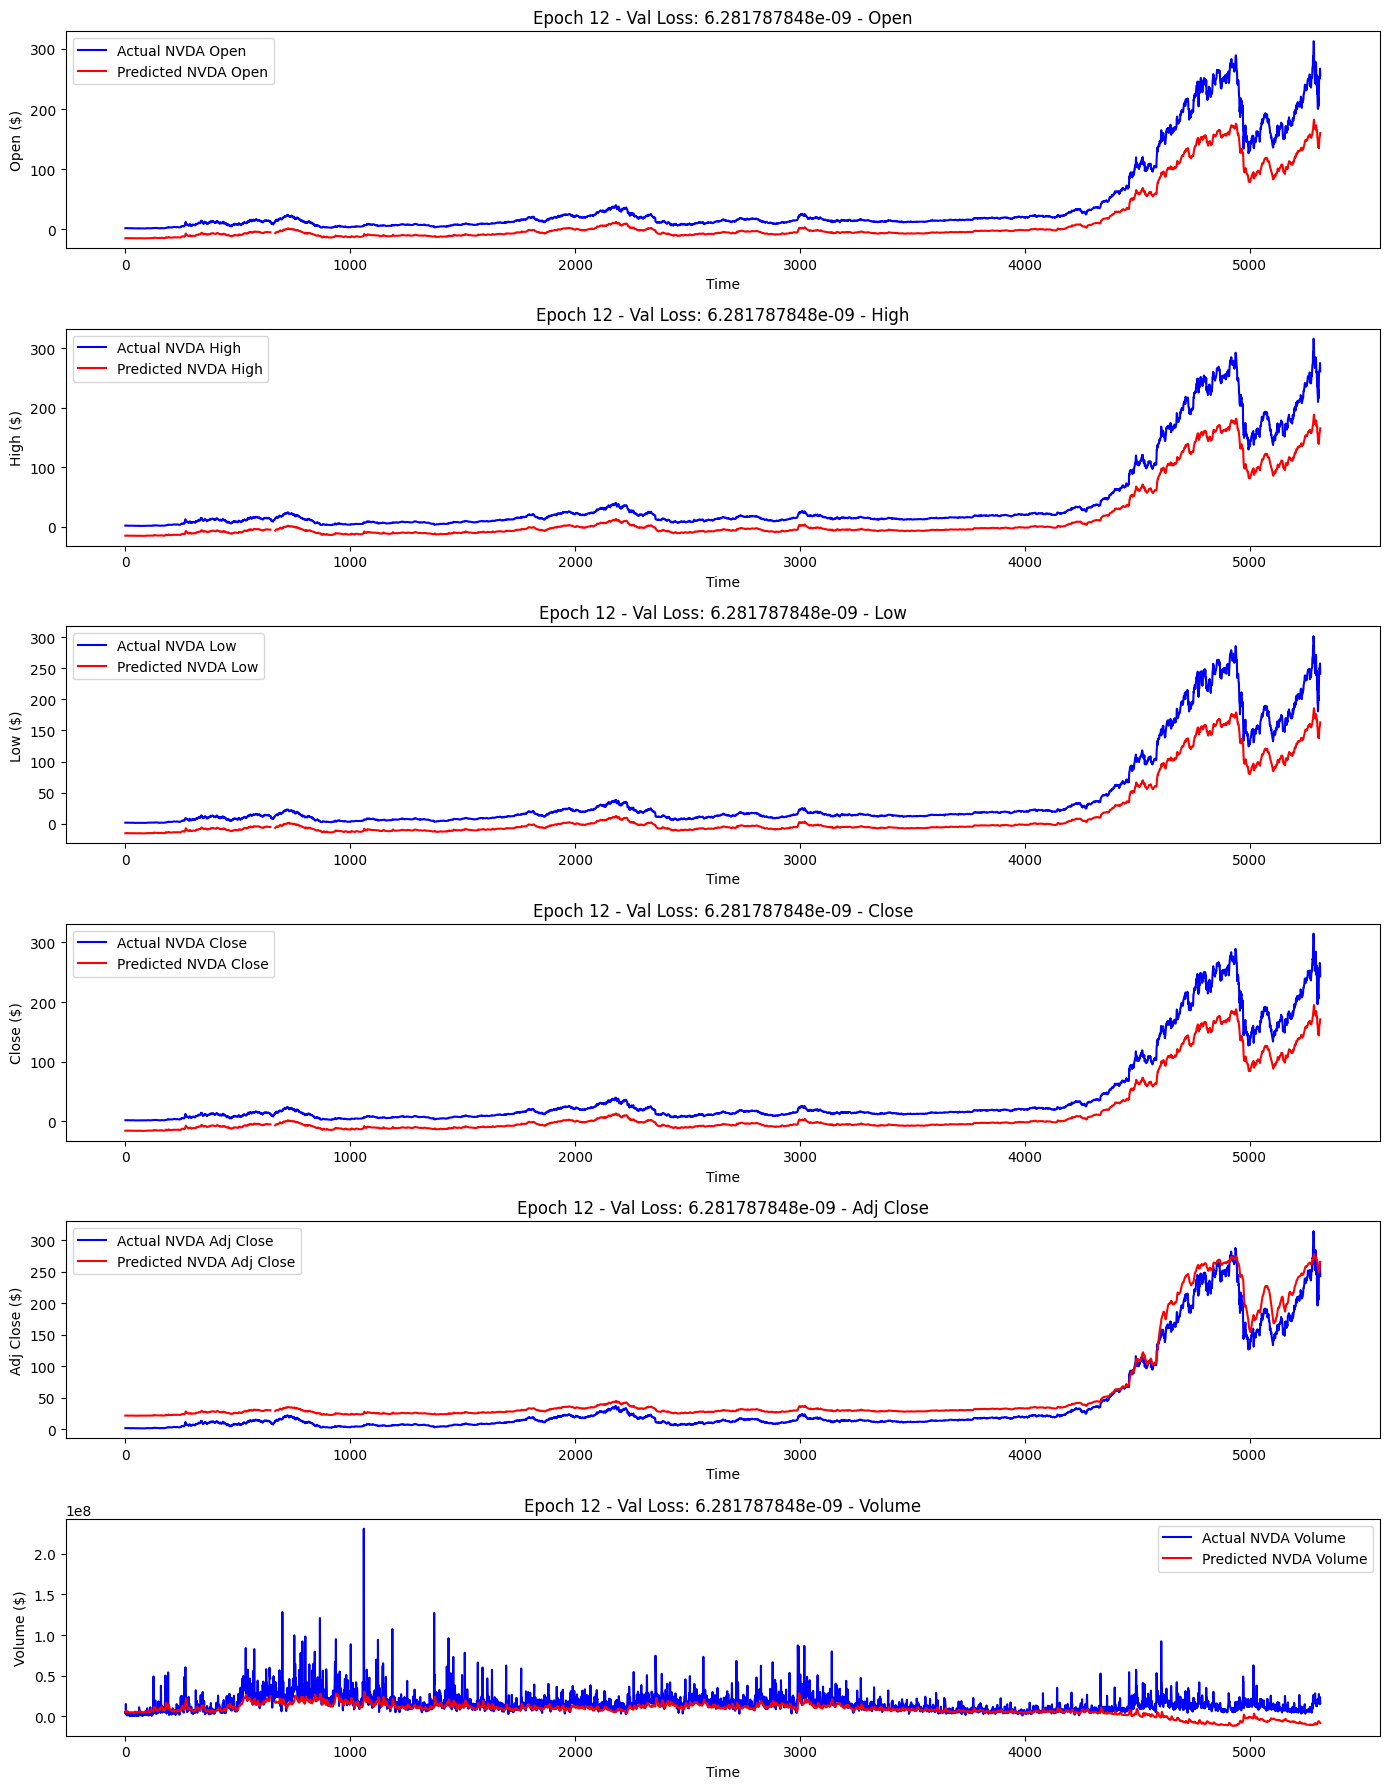

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

# --- Define the Model Architecture ---
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        # First LSTM layer: return sequences
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=256, num_layers=1, batch_first=True)
        self.dropout1 = nn.Dropout(0.3)
        # Second LSTM layer: return only final output (last timestep)
        self.lstm2 = nn.LSTM(input_size=256, hidden_size=256, num_layers=1, batch_first=True)
        self.dropout2 = nn.Dropout(0.3)
        # Dense output layer: same number of units as the number of features
        self.fc = nn.Linear(256, output_size)
        
    def forward(self, x):
        # x shape: (batch_size, look_back, input_size)
        out, _ = self.lstm1(x)           # out shape: (batch_size, look_back, 150)
        out = self.dropout1(out)
        out, _ = self.lstm2(out)         # out shape: (batch_size, look_back, 150)
        # Take the output from the final timestep
        out = out[:, -1, :]              # shape: (batch_size, 150)
        out = self.dropout2(out)
        out = self.fc(out)               # shape: (batch_size, output_size)
        return out

# --- Data Loading and Preprocessing ---
# Load the NVDA CSV file (ensure the file path is correct)
nvda_df = pd.read_csv('./data/stocks/nvda.csv')

# Convert the 'Date' column to datetime and set it as the index
nvda_df['Date'] = pd.to_datetime(nvda_df['Date'])
nvda_df.set_index('Date', inplace=True)

# Normalize the data using the scaler (assumed to be defined)
scaled_nvda = scaler.fit_transform(nvda_df)

# Check for NaN and infinity values
print("Checking for NaN values in data:", np.isnan(scaled_nvda).any())
print("Checking for infinity values in data:", np.isinf(scaled_nvda).any())

# Create dataset for NVDA using the provided create_dataset function (assumed to be defined)
X_nvda, y_nvda = create_dataset(scaled_nvda, look_back)

# Convert the input data to a PyTorch tensor
X_nvda_tensor = torch.from_numpy(X_nvda).float()

# --- Load the Trained Model from Best Epoch ---
input_size = nvda_df.shape[1]   # number of features
output_size = nvda_df.shape[1]    # same as input_size

model = LSTMModel(input_size=input_size, hidden_size=256, output_size=output_size)
model.load_state_dict(torch.load('mv3_best.pth'))
model.eval()

# --- Make Predictions for NVDA ---
with torch.no_grad():
    predictions_tensor = model(X_nvda_tensor)
    
# Convert predictions to a NumPy array
nvda_predictions = predictions_tensor.numpy()

# --- Inverse Transform the Predictions and Actual Values ---
nvda_predictions_full = np.zeros_like(scaled_nvda)
nvda_actual_full = np.zeros_like(scaled_nvda)

nvda_predictions_full[look_back:look_back+len(nvda_predictions), -nvda_predictions.shape[1]:] = nvda_predictions
nvda_actual_full[look_back:look_back+len(y_nvda), -y_nvda.shape[1]:] = y_nvda

# Perform inverse transformation to get values in the original scale
nvda_predictions = scaler.inverse_transform(nvda_predictions_full)[look_back:look_back+len(nvda_predictions), -nvda_predictions.shape[1]:]
nvda_actual = scaler.inverse_transform(nvda_actual_full)[look_back:look_back+len(y_nvda), -y_nvda.shape[1]:]

# --- Plotting the Results ---
# Select a section of the time for display (modify the slice as needed)
time_section = slice(0, 30000)

# Get all feature names from the original DataFrame
features = nvda_df.columns.tolist()
n_features = len(features)

plt.figure(figsize=(14, 3 * n_features))
for i, feature in enumerate(features):
    plt.subplot(n_features, 1, i+1)
    plt.plot(nvda_actual[time_section, i], color='blue', label=f'Actual NVDA {feature}')
    plt.plot(nvda_predictions[time_section, i], color='red', label=f'Predicted NVDA {feature}')
    plt.title(f"Epoch {BEST_EPOCH} - Val Loss: {BEST_VAL_LOSS:.9e} - {feature}")
    plt.xlabel('Time')
    plt.ylabel(f'{feature} ($)')
    plt.legend()

plt.tight_layout()
plt.show()